In [180]:
import numpy as np
import matplotlib.pyplot as plt

In [181]:
from keras.datasets import mnist

In [23]:
class Conv:
    def __init__(self, input_shape, filter_shape, num_filters=8):
        """
        input_shape -> channels * height * width
        filter_shape -> filter height * filter width
        num_filters -> number of filters
        output_shape -> num_filters * height_out * width_out
        """

        """
        Notations
        c ->  channels
        h -> image height
        w -> image width
        f -> number of filters
        fh -> filter height
        fw -> filter width
        h_out -> output image height
        w_out -> output image width
        """
        
        self.input_shape = (1,) + input_shape #input shape (1, c, h, w)
        self.filter_shape = (num_filters, self.input_shape[1], *filter_shape)#filter shape (f, c, fh,fw)
        
        # filter initialization (f * c * fh * fw)
        c, fh, fw = self.filter_shape[1:]
        self.filters = np.random.randn(*self.filter_shape)/(fh * fw * c) # dividing by (fh*fw) is important for xavier initialization
        self.b = np.zeros(self.filter_shape[0])  #bias term initialization
    
    def get_output_shape(self):
        """ returns the shape of the output of convolution operation"""
        h_out = self.input_shape[2] + 1 - self.filter_shape[2] #stride has been taken as 1
        w_out = self.input_shape[3] + 1 - self.filter_shape[3] #stride has been taken as 1
        return (self.filter_shape[0], h_out, w_out) #output shape (f, h_out, w_out)
        
        
    def iter_input(self, input_data, fh, fw, h_iter, w_iter):
        """ returns the slices of input data.
            fh, fw -> filter heights, filter widths
            h_iter, w_iter -> number of steps """
        for i in range(h_iter):
            for j in range(w_iter):
                img = input_data[:, :, i:i+fh, j:j+fw]
                yield i, j, img
        
    def forward(self, input_data, padding=False):
        """ computes output of layer on given input of shape (c, h, w) """
        input_data = input_data[np.newaxis, ...] #convert input data in shape (1, c, h, w)
        self.last_input = input_data #input saved for backprop phase
        
        h_out, w_out = self.get_output_shape()[1:] 
        fh, fw = self.filter_shape[2:]
        output = np.zeros(self.get_output_shape()) # (f, h_out, w_out) 
        
        for i, j, img_area in self.iter_input(input_data, fh, fw, h_out, w_out):
            output[:,i,j] = np.sum(self.filters * img_area, axis=(1, 2, 3)) + self.b #we are collapsing h,w dimensions by finding sum
        return output
    
    
    def backward(self, gradients, learn_rate=0.005):
        """ accept gradients as input in shape of (f, h_out, w_out) and 
        returns gradients as output in shape of (c, h, w) """
        #print("max grad", np.max(gradients), np.min(gradients))
        gradients = gradients.reshape((self.filter_shape[0], 1, gradients.shape[1], gradients.shape[2]))#convert gradients in shape (f, 1, h_out, w_out)
        
        #gradient terms intialization
        grad_filters = np.zeros(self.filters.shape)
        grad_b = np.zeros_like(self.b)
        grad_x = np.zeros(self.input_shape) #gradienst w. r. t. inputs
        
        grad_b = np.sum(gradients, axis=(1,2,3)) #easy huh? :)
        
        fh, fw = gradients.shape[2:] #filter sizes
        h_steps, w_steps = self.filter_shape[2:] #filter steps in both direction 
        for i, j, img_area in self.iter_input(self.last_input, fh, fw, h_steps, w_steps):
            grad_filters[:, :, i, j] = np.sum(img_area * gradients, axis=(2, 3)) 
        
        #update the gradients of the filters 
        #print("grad filters", grad_filters)
        #print("grad b", grad_b)
        self.grad_filters = grad_filters
        self.grad_b = grad_b
        self.filters -= learn_rate * grad_filters
        self.b -= learn_rate * grad_b
        #print("grad filter max", np.max(grad_filters))
        #what about grad_x :(
        return None

In [53]:
conv = Conv((1, 2, 2), (1, 1), 3)
img = np.array([[[1, 0], [0, 1]]])
out = conv.forward(img)
print(img)
print(out[0])
print(conv.filters[0, 0])
print(conv.b)

[[[1 0]
  [0 1]]]
[[0.58758998 0.        ]
 [0.         0.58758998]]
[[0.58758998]]
[0. 0. 0.]


In [186]:
class Maxpool:
    #this will apply max function to the input obtained from Conv layer
    def __init__(self, input_shape, pool_size=2):
        self.input_shape = input_shape
        self.pool_size = pool_size
        
    def get_output_shape(self):
        self.output_shape = list(self.input_shape)
        self.output_shape[0] = self.input_shape[0] // self.pool_size
        self.output_shape[1] = self.input_shape[1] // self.pool_size
        return tuple(self.output_shape)
    
    def iter_input(self, input_data):
        output_shape = self.get_output_shape()
        out_h, out_w = output_shape[0], output_shape[1]
        for i in range(out_h):
            for j in range(out_w):
                yield input_data[self.pool_size*i:self.pool_size*(i+1), self.pool_size*j:self.pool_size*(j+1)], i, j
    
    def forward(self, input_data):
        """ This function computes output after applying max filter"""
        self.last_input = input_data #saving data for backprop
        output = np.zeros(self.get_output_shape())
        for img_area, i, j in self.iter_input(input_data):
            out = np.amax(img_area, axis=(0, 1))
            output[i, j] = out
        return output
        
    def backward(self, gradients, learn_rate=0.03):
        """ take gradients of shape (w,h,t,f1, f2, ...) as input and 
        returns gradients as output in the same shape"""
        
        h, w = self.last_input.shape[0], self.last_input.shape[0]
        h_out, w_out = gradients.shape[0], gradients.shape[1]
    
        total_entries = np.array(self.last_input.shape).prod()
        changed_last_inputs = self.last_input.reshape((w,h, int(total_entries/(w*h))))
        out_grad = np.zeros(changed_last_inputs.shape)
        changed_gradients = gradients.reshape((w_out, h_out, changed_last_inputs.shape[2]))
        
        for img_area, i, j in self.iter_input(changed_last_inputs):
            max_val = np.amax(img_area, axis=(0, 1))
            for k, val in enumerate(max_val):
                x, y = np.where(img_area[:, :, k]==val)
                x, y = int(x[0]), int(y[0])
                changed_output_grad[self.pool_size * i + x, self.pool_size*j + y, k] = changed_gradients[i, j, k]     
        out_grad = changed_output_grad.reshape(self.input_shape)
        return out_grad

In [38]:
max_layer = Maxpool((7,7, 8),2)
img = np.ones((7, 7, 8))
out = max_layer.get_output_shape()
#print(out)
output = max_layer.forward(img)
print(output.shape)

(3, 3, 8)


In [ ]:
#Testing both the layers 
#forward phase
layer_1 = Conv((28, 28), num_filters=8)
#print(layer_1.get_output_shape())
img = np.ones((28, 28))
output = layer_1.forward(img)
max_layer = Maxpool(output.shape,2)
out = max_layer.get_output_shape()
#print(out)
output = max_layer.forward(img)
print(output.shape)


In [42]:
#checking backprop of the  Maxpool layer
max_layer = Maxpool((9, 9, 3, 2), 2)
img = np.random.randint(250, size=(9,9,3,2))
out_1 = max_layer.forward(img)
grad = np.random.randint(10, size=out_1.shape)
accha = max_layer.backward(grad)
print(grad.shape)
print(accha.shape)

(4, 4, 3, 2)
(9, 9, 3, 2)


In [106]:
class Softmax:
    def __init__(self, input_len, nodes=100):
        self.input_len = input_len
        self.output_len = nodes
        
        #initializing weight and biases
        self.W = np.random.randn(self.input_len, self.output_len) / (self.input_len * self.output_len) #shape(output_len, input_len)
        self.b = np.zeros(self.output_len)#shape(output_len, )

    def forward(self, input_data):
        self.original_input_shape = input_data.shape #for backward phase
        
        #first we will flatten the input data
        input_data = input_data.flatten() #shape (input_len, )
        input_data = input_data / np.max(input_data)
        #input_data = input_data[:, np.newaxis] #shape (input_len, 1)
        z = np.dot(input_data, self.W) + self.b #shape (output_len, )
        self.last_input = input_data #flattened input for backward phase
        #z = z - np.max(z)
        self.last_z = z #z vector for backward phase
        #if (abs(np.sum(np.exp(z), axis=0))<=10**-8):
        #    print("z went 0", z)
        return np.exp(z) / np.sum(np.exp(z), axis=0) 
    
    def backward(self, gradients, learn_rate=0.005):
        """ it takes gradients with respect to layer-outputs (dcost/da^(L)) as input, update weights and biases, and
        return gradients with respect to the layer-inputs(dcost/da^(L-1))"""
        

        #finding the index where gradient is non zero
        index = int(np.where(gradients != 0)[0])
        
        #denominator term of softmax function
        S = np.sum(np.exp(self.last_z)) 
        
        #dp_dz vector
        dp_dz = np.zeros_like(gradients) #(output_len, )
        dp_dz = - (np.exp(self.last_z)[index] * np.exp(self.last_z))/ (S ** 2)
        dp_dz[index] = np.exp(self.last_z)[index] *(S - np.exp(self.last_z)[index])/ (S ** 2) 

        
        #dc_dz
        dc_dz = gradients[index] * dp_dz
        #gradients of cost w.r.t weights, biases and inputs
        
        
        dc_Dw = self.last_input[np.newaxis].T @ dc_dz[np.newaxis] 
        dc_db = dc_dz
        dc_da = self.W @ dc_dz
        #update the weights and biases
        self.W -= learn_rate * dc_Dw
        self.b -= learn_rate * dc_db
        
        #reshape the input gradients in original input form and return
        return dc_da.reshape(self.original_input_shape)

In [80]:
input_vect = np.array([[0,1], [1,0]])
soft = Softmax(4, 2)
out = soft.forward(input_vect)


In [163]:
#test the softmax
input_vect = np.array([[2,2], [1,3]])
soft = Softmax(4, 2)
out = soft.forward(input_vect)
print(out)
y = 1
for i in range(100):
    grad = np.zeros(out.shape)
    grad[y] = -1/np.log(out[y])
    soft.backward(grad)
    out = soft.forward(input_vect)
print(out)

[0.25906534 0.74093466]
[3.7660374e-05 9.9996234e-01]


In [215]:
##loading the data 
data = mnist.load_data()
((x_train, y_train), (x_test, y_test)) = data
x_train, y_train = x_train[:1000], y_train[:1000]
print(x_train.shape)
print(y_train.shape)

(1000, 28, 28)
(1000,)


In [214]:
x = x_train[0][np.newaxis,...]
print(x.shape)

(1, 28, 28)


In [257]:
def forward(img, label):
    #forward step
    out = conv.forward((img[np.newaxis, ...]/255)-0.5)
    #out = conv_2.forward(out)
    #out = pool.forward(out)
    out = soft.forward(out)
    #compute loss and accuracy
    loss = -max(np.log(out[label]), -10**10) #cross entropy
    acc = 1 if (np.argmax(out) == label) else 0
    
    return out, loss, acc

In [258]:
def train(img, label, lr=0.005):
    #forward
    out, loss, acc = forward(img, label)
    
    #calculate gradients
    gradient = np.zeros(10)
    gradient[label] = -1/max(out[label], 10 ** -6)
    #print("gradient", gradient)
    #backprop
    gradient = soft.backward(gradient, lr)
    #gradient = pool.backward(gradient)
    gradient = conv.backward(gradient)
    #print("z", soft.last_z.flatten(), label)
    #print("p", out)
    #print ("dc_dz", soft.dc_dz.flatten())

    
    return loss, acc

In [252]:
input_shape = (1, 28, 28)
conv  = Conv(input_shape, filter_shape=(4,4), num_filters=2)
conv_shape = conv.get_output_shape()
#conv  = Conv(input_shape, filter_shape=(4,4), num_filters=2)
#conv_shape = conv.get_output_shape()
#pool = Maxpool(conv_shape, 2)
#pool_shape = pool.get_output_shape()
num_features = np.prod(np.array(conv_shape))
print(num_features)
output_features = 10
soft = Softmax(num_features, output_features)

print('CNN initialized')
for epoch in range(2):
    print("running the epoch;", epoch)
    #shuffle the training examples
    permutation = np.random.permutation(len(x_train))
    x_train = x_train[permutation]
    y_train = y_train[permutation]

    #Training the forward phase
    num_correct = 0
    loss = 0
    for i, (img, label) in enumerate(zip(x_train, y_train)):
        #print("count", i)
        if i % 100 == 99:
            print(
                '[Step %d] Past 100 steps: Average Loss %.3f | Accuracy: %d%%' %
                (i + 1, loss / 100, num_correct)
            )
            #print("z", soft.last_z.flatten(), label)
            loss = 0
            num_correct = 0

        l, acc = train(img, label)
        loss += l
        num_correct += acc

1250
CNN initialized
running the epoch; 0


NameError: name 'conv_2' is not defined

In [ ]:
input_shape = (1, 28, 28)
conv  = Conv(input_shape, filter_shape=(3,3), num_filters=10)
conv_shape = conv.get_output_shape()
#conv_2 = Conv(conv_shape, filter_shape=(3,3), num_filters=3)
#conv_2_shape = conv_2.get_output_shape()
#conv  = Conv(input_shape, filter_shape=(4,4), num_filters=2)
#conv_shape = conv.get_output_shape()
#pool = Maxpool(conv_shape, 2)
#pool_shape = pool.get_output_shape()
num_features = np.prod(np.array(conv_shape))
print(num_features)
output_features = 10
soft = Softmax(num_features, output_features)

print('CNN initialized')
for epoch in range(3):
    print("running the epoch;", epoch)
    #shuffle the training examples
    permutation = np.random.permutation(len(x_train))
    x_train = x_train[permutation]
    y_train = y_train[permutation]

    #Training the forward phase
    num_correct = 0
    loss = 0
    for i, (img, label) in enumerate(zip(x_train, y_train)):
        #print("count", i)
        if i % 100 == 99:
            print(
                '[Step %d] Past 100 steps: Average Loss %.3f | Accuracy: %d%%' %
                (i + 1, loss / 100, num_correct)
            )
            #print("z", soft.last_z.flatten(), label)
            loss = 0
            num_correct = 0

        l, acc = train(img, label)
        loss += l
        num_correct += acc

6760
CNN initialized
running the epoch; 0
[Step 100] Past 100 steps: Average Loss 1.614 | Accuracy: 48%
[Step 200] Past 100 steps: Average Loss 1.116 | Accuracy: 59%
[Step 300] Past 100 steps: Average Loss 0.878 | Accuracy: 71%
[Step 400] Past 100 steps: Average Loss 0.977 | Accuracy: 68%
[Step 500] Past 100 steps: Average Loss 0.726 | Accuracy: 77%
[Step 600] Past 100 steps: Average Loss 0.993 | Accuracy: 67%
[Step 700] Past 100 steps: Average Loss 0.742 | Accuracy: 76%
[Step 800] Past 100 steps: Average Loss 0.868 | Accuracy: 69%
[Step 900] Past 100 steps: Average Loss 0.743 | Accuracy: 75%
[Step 1000] Past 100 steps: Average Loss 0.685 | Accuracy: 75%
[Step 1100] Past 100 steps: Average Loss 0.656 | Accuracy: 78%
[Step 1200] Past 100 steps: Average Loss 0.663 | Accuracy: 77%
[Step 1300] Past 100 steps: Average Loss 0.563 | Accuracy: 80%
[Step 1400] Past 100 steps: Average Loss 0.513 | Accuracy: 81%
[Step 1500] Past 100 steps: Average Loss 0.908 | Accuracy: 72%
[Step 1600] Past 100 s

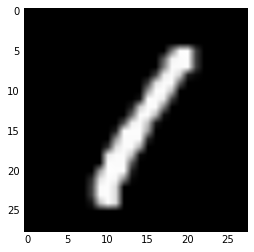

In [228]:
#visualizing the filters
img = x_train[3]
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
img = img[np.newaxis, ...]
out = conv.forward(img)

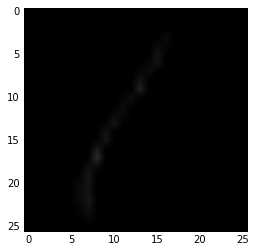

In [233]:
plt.imshow(out[4], cmap='gray', vmin=0, vmax=255)

In [204]:
conv.filters[2, 0]

array([[-0.13901809,  0.12804853,  0.05074609],
       [ 0.00905267, -0.0960619 ,  0.18055336],
       [ 0.09185021,  0.19787026,  0.00338203]])

In [196]:
from keras.datasets import fashion_mnist

In [236]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, y_train = x_train[:2000], y_train[:2000]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [249]:
input_shape = (1, 28, 28)
conv  = Conv(input_shape, filter_shape=(5,5), num_filters=8)
conv_shape = conv.get_output_shape()
#conv  = Conv(input_shape, filter_shape=(4,4), num_filters=2)
#conv_shape = conv.get_output_shape()
#pool = Maxpool(conv_shape, 2)
#pool_shape = pool.get_output_shape()
num_features = np.prod(np.array(conv_shape))
print(num_features)
output_features = 10
soft = Softmax(num_features, output_features)

print('CNN initialized')
for epoch in range(2):
    print("running the epoch;", epoch)
    #shuffle the training examples
    permutation = np.random.permutation(len(x_train))
    x_train = x_train[permutation]
    y_train = y_train[permutation]

    #Training the forward phase
    num_correct = 0
    loss = 0
    for i, (img, label) in enumerate(zip(x_train, y_train)):
        #print("count", i)
        if i % 100 == 99:
            print(
                '[Step %d] Past 100 steps: Average Loss %.3f | Accuracy: %d%%' %
                (i + 1, loss / 100, num_correct)
            )
            #print("z", soft.last_z.flatten(), label)
            loss = 0
            num_correct = 0

        l, acc = train(img, label)
        loss += l
        num_correct += acc

4608
CNN initialized
running the epoch; 0
[Step 100] Past 100 steps: Average Loss 1.552 | Accuracy: 46%
[Step 200] Past 100 steps: Average Loss 1.117 | Accuracy: 60%
[Step 300] Past 100 steps: Average Loss 0.899 | Accuracy: 66%
[Step 400] Past 100 steps: Average Loss 0.798 | Accuracy: 73%
[Step 500] Past 100 steps: Average Loss 0.995 | Accuracy: 63%
[Step 600] Past 100 steps: Average Loss 0.891 | Accuracy: 67%
[Step 700] Past 100 steps: Average Loss 0.874 | Accuracy: 72%
[Step 800] Past 100 steps: Average Loss 0.776 | Accuracy: 72%
[Step 900] Past 100 steps: Average Loss 0.757 | Accuracy: 76%
[Step 1000] Past 100 steps: Average Loss 0.774 | Accuracy: 72%
[Step 1100] Past 100 steps: Average Loss 0.705 | Accuracy: 76%
[Step 1200] Past 100 steps: Average Loss 0.825 | Accuracy: 78%
[Step 1300] Past 100 steps: Average Loss 0.796 | Accuracy: 73%
[Step 1400] Past 100 steps: Average Loss 0.680 | Accuracy: 79%
[Step 1500] Past 100 steps: Average Loss 0.578 | Accuracy: 79%
[Step 1600] Past 100 s